![header](https://i.imgur.com/I4ake6d.jpg)

# Operational Modelling Workshop 

# Table of contents

- [1. Introduction](#1.-Introduction)
  - Environment Setup
- [2. Subset and dowload data using motuclient](#2.-Subset-and-dowload-data-using-motuclient)
- [3. Read the files downloaded and access its metadata](#3.-Read-the-files-downloaded-and-access-its-metadata)
- [4. Data conversion](#4.-Data-conversion)
  - Conversion to CSV
  - Conversion to Shapefile
- [5. Plot the Data](#5.-Plot-the-Data)
  - Data visualization at global scale
  - Map creation at local scale 
- [6. Recursive data plotting](#6.-Recursive-data-plotting)
  - Plots Animation (Gif)
***

## 1. Introduction

We will focus on the following product (available on the [Copernicus Catalogue](http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&task=results)):
- [SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001](http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001)

This product data uses satellite data provided by the [GHRSST project](https://www.ghrsst.org) together with in-situ observations, to determine the sea surface temperature.

![product-overview-010-001](https://i.imgur.com/rfBH21a.png)

- `Level4`: Data have had the greatest amount of processing applied, possibly including modelled output and measurements from several satellites and several days. All input data are validated.

To access the full product information page and its download services, documentation and New flash please click [here](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=details&product_id=SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001)

**Please remember that this product has two resolutions, 0.05°x 0.05°  and 0.25°x 0.25° as the highest and lowest resolution respectively. The resolution that appears is the product information page (0.05°x 0.05°) is relative just to the following dataset:**

- **METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2**

### 1.1 Environment Setup

There are two options to reproduce the content of this workshop:

- **No install - ready to use**: To launch anytime this environment on the cloud from a web browser, click here https://tiny.cc/20200527
- **Regular Jupyter installation**: To execute this environment and [notebook](https://github.com/copernicusmarine/copernicus-jupyter-notebook-gallery/blob/master/10-01-Subset-Download-Read-Convert-Plot-NetCDF-files-over-Global-Ocean.ipynb) on a local machine, follow these instructions: https://tiny.cc/copernicus-training

The computing language used to perform the analysis on the selected data, is **"Python"**. In order to subset, download, read, convert and plot the data, the next and very first code cell enables the access to required tools. 

In [1]:
import csv
import glob
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import moviepy.editor as mpy

import numpy as np
import pandas as pd
import shapefile
import xarray as xr
from fiona import collection

from matplotlib.dates import date2num, num2date
from mpl_toolkits.basemap import Basemap

from natsort import natsorted

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon

warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Subset and dowload data using motuclient 

The motuclient scripts to request and download the data from the SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001 product, in both the montly-mean (2020-04-15) and daily-mean (from 2020-04-01 to 2020-04-30) datasets (lower resolution 0.25°x 0.25°), are showed below. 

The files saved are called "download_motuclient.nc" and "download_motuclient30days" respectively and they are going to be automatically stored, once downloaded, inside the "Data" folder. 

The only variable downloaded and used in this tutorial is the "analysed_sst" (long mame: "analysed sea surface temperature") expressed in Kelvin. Furthermore It is set for both the data requests the same geographic bounding box. 

**Below you need to type the CMEMS log in credentials (in between "") to be able downloading data:**

In [2]:
Username = ""
Password = ""

**One month data request (from monthly-mean dataset):**

In [3]:
!python -m motuclient \
 --user $Username --pwd $Password \
 --motu http://nrt.cmems-du.eu/motu-web/Motu \
 --service-id SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001-TDS \
 --product-id METOFFICE-GLO-SST-L4-NRT-OBS-SST-MON-V2 \
 --longitude-min -15 --longitude-max 0 \
 --latitude-min 35 --latitude-max 45 \
 --date-min "2020-04-15 12:00:00" --date-max "2020-04-15 12:00:00" \
 --variable analysed_sst \
 --out-dir Data --out-name download_motuclient.nc

**30 days data request (from daily-mean dataset):**

In [4]:
!python -m motuclient \
 --user $Username --pwd $Password \
 --motu http://nrt.cmems-du.eu/motu-web/Motu \
 --service-id SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001-TDS \
 --product-id METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2 \
 --longitude-min -15 --longitude-max 0 \
 --latitude-min 35 --latitude-max 45 \
 --date-min "2020-04-01 12:00:00" --date-max "2020-04-30 12:00:00" \
 --variable analysed_sst \
 --out-dir Data --out-name download_motuclient30days.nc

## 3. Read the files downloaded and access its metadata

**For the monthly-mean file:**

In [5]:
#Path where the data file is located
data = "Data/download_motuclient.nc"

In [6]:
#Read the data as dataset (DS)
DS = xr.open_dataset(data)

In [ ]:
#Show the metadata
DS

In [8]:
#Extract from the dataset (DS) the variable needed
lons = DS.variables['lon'][:]
lats = DS.variables['lat'][:]
sst = DS.variables['analysed_sst'][0, :, :]  #[time,lat,long]

In [9]:
#It is good habit to close a dataset (DS) when done
DS.close()

**For the daily-mean file:**

In [10]:
data30days = "Data/download_motuclient30days.nc"

In [11]:
DS30d = xr.open_dataset(data30days)

In [ ]:
DS30d

In [13]:
DS30d.close()

## 4. Data conversion

The NetCDF format is used to store multidimentional scientific data. As Python many programming language and softwares are able to access the NetCDF files. However, sometime can be handy to convert them in others formats as can be the "csv" (or "Comma Separated Value" where each row is identified as a single data "record") and the "Shapefile"(Geospatial vector data format for geographic information system software which is developed and regulated by Esdri) file format. Below an example of conversion in "CSV" and "Shapefile":

### 4.1 Conversion to CSV

In [ ]:
#Read the file and leave the times in our file encoded as numbers. We create a dataset called "ds"
ds = xr.open_dataset("Data/download_motuclient.nc", decode_times=False)
ds

In [ ]:
# Convert our dataset in a dataframe called "df" where the data is organise in a tabular form
df = ds.to_dataframe()
df

In [16]:
#The entire dataframe (also the "NaN" values) is converted as csv file
df.to_csv("Data/CSV/download_motuclient.csv")

#Another csv file, whithout "NaN" values, is produced
data = pd.read_csv("Data/CSV/download_motuclient.csv")
data.dropna().to_csv("Data/CSV/download_motuclient_NoNAN.csv", index = False)

### 4.2 Conversion to Shapefile

To produce the "shapefile" we are going to use the csv file generated before. In particular we are going to use the one without NaN values (called "download_motuclient_NoNAN.csv"). We proceed like that to avoid that in our shapefile are going to be included empty or not valid records (in land data aquisition for example). The geometry of the shapefile choosen which rapresent the best our data is the "Point" and then starting from our csv we are going to generate a 2d cloud of point desribing the "analised_sst" data distribution. Below the code to convert our csv in a shapefile:  

In [17]:
filecsv = open("Data/CSV/download_motuclient_NoNAN.csv")

listed=[]
line = filecsv.readline()
for u in line.split(','):
    listed.append(u)
    
variable = "analysed_sst"

schema = { 'geometry': 'Point', 'properties': { variable : 'float' } }
with collection("Data/SHP/download_motuclient_NoNAN.shp", "w", "ESRI Shapefile", schema) as output:
    with open("Data/CSV/download_motuclient_NoNAN.csv", 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            point = Point(float(row['lon']), float(row['lat']))
            output.write({
                  'properties': {
                      variable: row[variable]
                  },
                
                  'geometry': mapping(point)
            })

In [18]:
#To read the shapefile generated
sf = shapefile.Reader("Data/SHP/download_motuclient_NoNAN.shp")

In [19]:
#To check the total number of records
len(sf)

1569

In [20]:
#To show the first 10 records of the "analysed_sst" variable
sf.records()[0:10]

[Record #0: [290.91],
 Record #1: [290.8],
 Record #2: [290.71],
 Record #3: [290.65],
 Record #4: [290.66],
 Record #5: [290.68],
 Record #6: [290.78997999999996],
 Record #7: [290.9],
 Record #8: [290.9],
 Record #9: [290.93]]

To verify and check that the shapefile was generated correctly it is better to plot it (process done by the code below). It is interesting to see all the nodes or the data records (showed as red dots) inside the area of interest. In fact, The distance between each node or record is 0.25 degree as the product documentation can testify.  

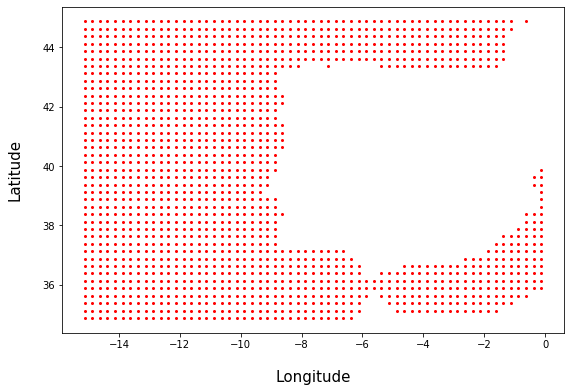

In [21]:
plt.rcParams["figure.figsize"] = (9,6)

listx=[]
listy=[]
T =[]
for sr in sf.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew-360)
        listy.append(yNew)
            

plt.xlabel("Longitude", fontsize=15, labelpad=20)
plt.ylabel("Latitude", fontsize=15, labelpad=20)           
plt.plot(listx,listy,'ro', markersize=2)
plt.show()

## 5. Plot the Data
In this section will be shown how to visualise the data in both global and local scale (that will give us a more detailed map). For this purpose we are going to use the monthly-mean file downloaded previously and stored as "download_motuclient.nc".

### 5.1 Data visualization at global scale

In the following plot a red poligon is overlayed in the location where we expect to visualise the data.

In [ ]:
plt.rcParams["figure.figsize"] = (18,12)

ax = plt.axes(projection=ccrs.PlateCarree())

plt.title('SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001 - 2020-04-15')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.ylabels_left = False

ax.stock_img()
ax.coastlines()

#Area where we expect to have the data  
pgon = Polygon(((-15, 35),(-15,45),(0,45),(0,35)))
ax.add_geometries([pgon], crs=ccrs.PlateCarree(), facecolor = 'r', edgecolor='red', alpha=0.5)

plt.show()

Once we add the data to the plot above we can see as the area previously covered by a red polygon now contains the  "analysed_sst" data. It is just a preliminary plot just to have a general ata overview in a global map context.

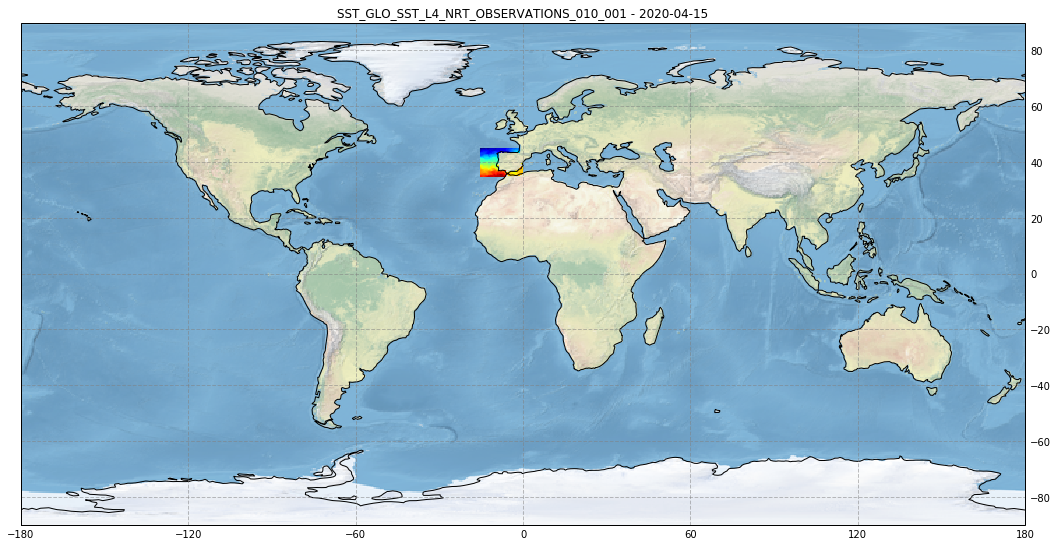

In [23]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.title('SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001 - 2020-04-15')

#Data added to the plot
plt.contourf(lons, lats, sst, 60, cmap='jet',
             transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.ylabels_left = False

ax.stock_img()
ax.coastlines()

plt.show()

### 5.2 Map creation at local scale
At this point we can create a detailed map (just related to the data inside its bounding box) which will give us a clearer idea of the data distribution and lead as to a better data insight.

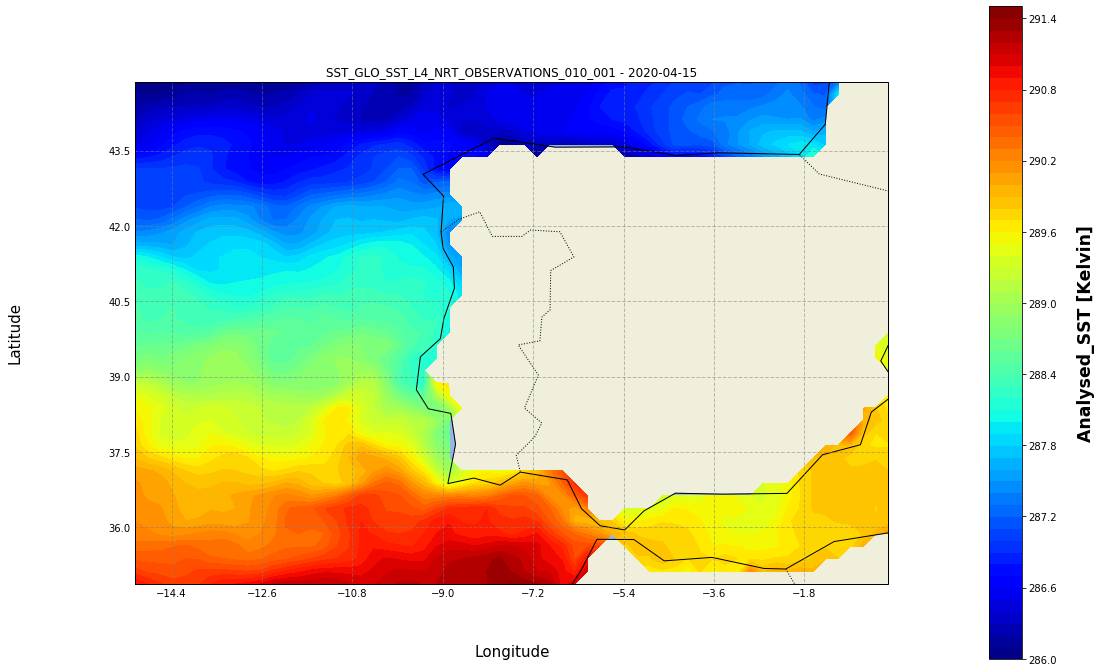

In [24]:
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

plt.title('SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001 - 2020-04-15')

plt.contourf(lons, lats, sst, 60, cmap='jet',
             transform=ccrs.PlateCarree())

cb = plt.colorbar(orientation="vertical", pad=0.1)
cb.set_label(label='Analysed_SST [Kelvin]', size='xx-large', weight='bold',labelpad=20)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False

ax.text(-0.15, 0.5, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=15)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=15)

plt.show()

And if we convert in Celcius degree:

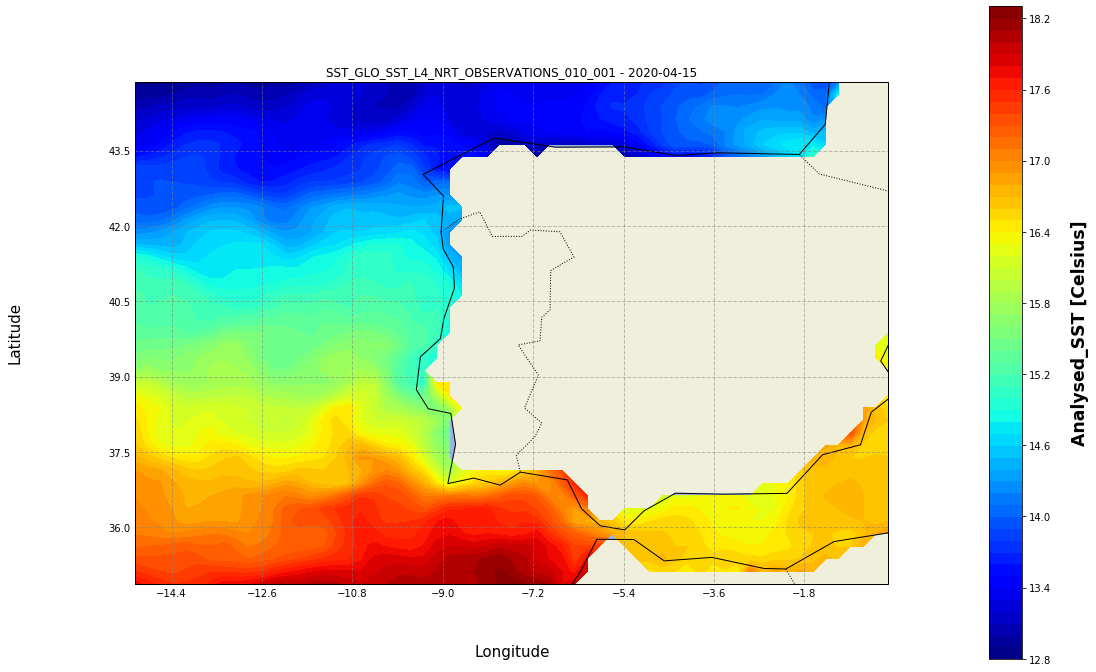

In [25]:
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

plt.title('SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001 - 2020-04-15')

sstC= sst-273.15

plt.contourf(lons, lats, sstC, 60, cmap='jet',
             transform=ccrs.PlateCarree())

cb = plt.colorbar(orientation="vertical", pad=0.1)
cb.set_label(label='Analysed_SST [Celsius]', size='xx-large', weight='bold',labelpad=20)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False

ax.text(-0.15, 0.5, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=15)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=15)

plt.show()

## 6. Recursive data plotting 

This section is pretty useful to plot recursively many plots of the same variable in fuction of the time. For this process It is used the 30 days file downloaded previously and saved as "download_motuclient30days.nc". We also need to find the maximum and minimum value of the "analysed_sst" variable contained in the file downloaded  so to set a fixed scale bar that is going to be used for all the plots (Doing that will allow the comparison of the plots in fuction of the time and then the "analysed_sst" value map variation will be displayed  using always the same color scale range). Are going to be produced a total of 30 plots, one for each time steps (30 days). 

In [ ]:
plt.rcParams["figure.figsize"] = (9,6)

with xr.open_dataset('Data/download_motuclient30days.nc') as file:
    
    minvar = file.analysed_sst.min()
    maxvar = file.analysed_sst.max()
    
    for t in range(file.time.shape[0]):
        
        da = file.analysed_sst.isel(time=t)
        
        num = date2num(file.time[t])
        date = num2date(num)
        
        lat  = file.variables['lat'][:]
        lon  = file.variables['lon'][:]
        
        title = file.id+" "+"-"+" "+str(date)
        
        plt.title(title, fontsize=10)
        plt.xlabel("Longitude", fontsize=15, labelpad=40)
        plt.ylabel("Latitude", fontsize=15, labelpad=50)
        
        m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon.min(), \
        urcrnrlon=lon.max(),llcrnrlat=lat.min(),urcrnrlat=lat.max(), \
        resolution='h')
        
        m.drawcoastlines()
        m.fillcontinents()
        m.drawmapboundary()
        
        m.drawparallels(np.arange(-80., 81., 2.5), labels=[1,0,0,0], fontsize=15)
        m.drawmeridians(np.arange(-180., 181., 2.5), labels=[0,0,0,1], fontsize=15)

        x, y = m(*np.meshgrid(lon,lat))

        col = m.pcolormesh(x,y,da,shading='flat',cmap=plt.cm.jet, vmin=minvar, vmax=maxvar)
        
        cbar = plt.colorbar(col)
        
        
        cbar.ax.yaxis.set_ticks_position('right')
        for I in cbar.ax.yaxis.get_ticklabels():
            I.set_size(10)
        
        cbar.set_label("Analysed_SST", size = 15, weight='bold',labelpad=20)
        
        plt.savefig('Data/PNG/{}.png'.format(t), dpi=100)
        
        plt.show()

### 6.1 Plots animation (Gif)

Below the code that will allow to stack all the plots obtained before in an animated GIF file: 

In [27]:
gif_name = 'Analysed_SST'
fps = 2

file_list = glob.glob('Data/PNG/*.png') # Get all the pngs in the current directory
lsorted = natsorted(file_list)
#file_list.sort(key=os.path.getmtime) # Sort the images by generation time

clip = mpy.ImageSequenceClip(lsorted, fps=fps)
clip.write_gif('Data/GIF/{}.gif'.format(gif_name), fps=fps)

t:  10%|█         | 3/30 [00:00<00:01, 24.24it/s, now=None]

MoviePy - Building file Data/GIF/Analysed_SST.gif with imageio.


Finally we can plot the gif file generated above as following:

In [28]:
from IPython.display import display, HTML

HTML('''<div style="display: flex; justify-content: row;">
    <img src="Data/GIF/Analysed_SST.gif">
    
</div>''')

-----------------

---------------

![thank-you](https://i.imgur.com/biwgCJP.jpg)